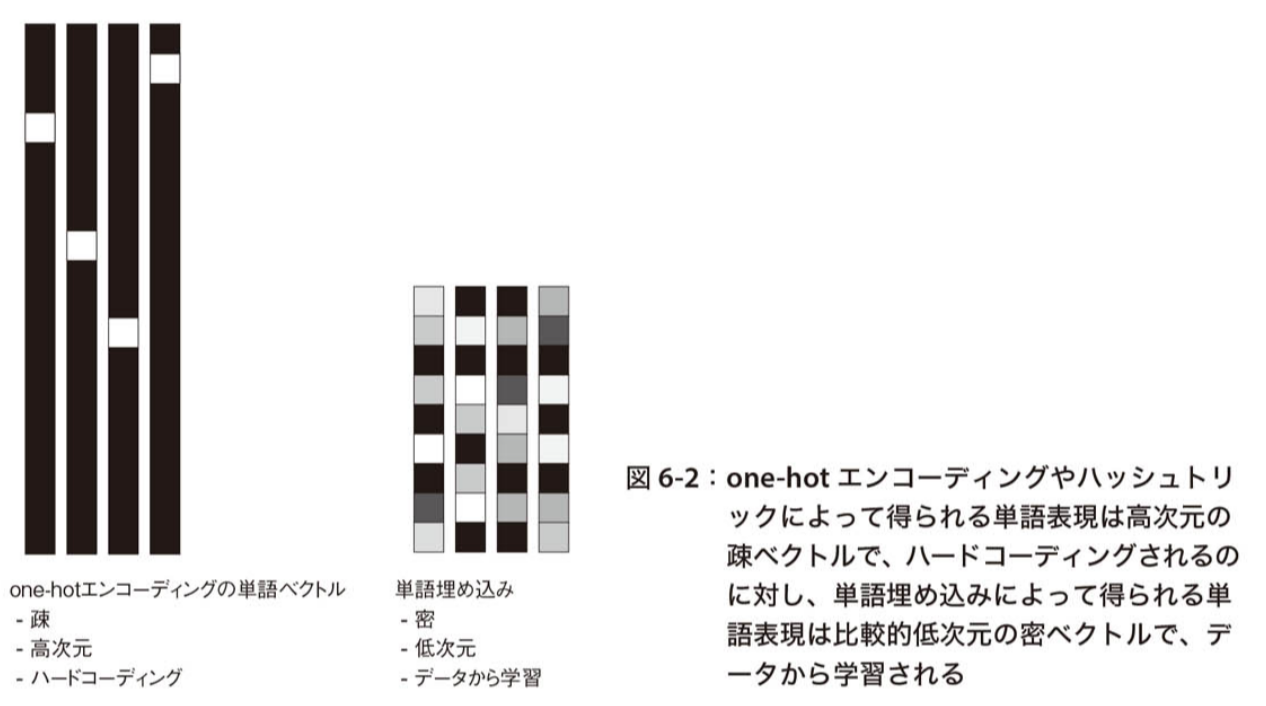

In [1]:
# 画像の表示
from IPython.display import Image
Image(filename='01.png', width=600)

単語埋め込みを取得するには２つの方法が存在する。<br>
<ol>
    <li>メインのタスク（文章分類や感情予測）と同時に単語埋め込みを学習</li>
    <li>別の機械学習タスクを使って計算された単語埋め込みをモデルに読み込む</li>
</ol>

単語埋め込み空間の良し悪しはタスクに大きく依存。<br>
英語の映画レビューの感情分析モデルにとって申し分のない単語埋め込み空間は、<br>
英語の法的文書の分類モデルにとって申し分のない単語埋め込み空間とは違って見える。<br>

In [2]:
# embedding層をインスタンス化
from keras.layers import Embedding

# Embedding層の引数は少なくとも２つ
# 有効なトークンの数　：　この場合は1,000(1+単語のインデックスの最大値)
# 埋め込みの次元の数 : この場合は64
embedding_layer = Embedding(1000, 64)

Using TensorFlow backend.


Embedding層については、（特定の単語を表す）整数のインデックスを密ベクトルにマッピングするディクショナリとして考えてみる。<br>
層は入力として整数を受け取り、それらの整数を内部のディクショナリで検索し、それらの整数に関連付けられているベクトルを返す。<br>

Embedding層から返されるのは、形状が（samples, sequence_length, embedding_dimensionality）の浮動小数点型の3次元テンソル。<br>

Embedding層をインスタンス化する際には、他の層と同様に、層の重みがランダムに初期化される。<br>

### EmbeddingをIMDbに当てはめる

IMDbの感情予測タスクに当てはめる。<br>
10,000個の単語に映画レビューを絞り込み、20個の単語を残して映画レビューを切り捨て。<br>

In [3]:
from keras.datasets import imdb
from keras import preprocessing

# 特徴量として考慮する単語の個数
max_features = 1000

# max_features個の最も出現頻度の高い単語のうち
# この数の単語を残してテキストをカット
max_len = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

In [4]:
# 形状をみる
x_train.shape, x_test.shape

((25000,), (25000,))

In [5]:
# 整数のリストを形状が（samples, max_len）の整数型の２次元テンソルに変換
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_train.shape

(25000, 20)

In [6]:
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
x_test.shape

(25000, 20)

10,000個の単語ごとに8次元の埋め込みを学習し、<br>
入力である整数シーケンス（整数型の２次元テンソル）を埋め込みシーケンス（浮動小数点数型の３次元テンソル）<br>
に変換し、テンソルを２次元に平坦化。<br>

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()

# 後から埋め込み入力を平坦化できるよう、
# Embedding層に入力の長さとしてmax_lenを指定
# Embedding層の後、活性化の形状は(samples, max_len, 8)になる
model.add(Embedding(10000, 8, input_length=max_len))

# 埋め込みの３次元テンソルを形状が(samples, max_len * 8)の２次元テンソルに変換
model.add(Flatten())

# 最後に分類器を追加
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop',
                            loss = 'binary_crossentropy',
                          metrics=['acc']
             )

model.summary()

history = model.fit(x_train, y_train,
                                epochs = 10,
                               batch_size = 32,
                                validation_split = 0.2
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 69us/step - loss: 0.6771 - acc: 0.6005 - val_loss: 0.6447 - val_acc: 0.6706
Epoch 2/10
20000/20000 [==============================] - 1s 64us/step - loss: 0.5829 - acc: 0.7186 - val_loss: 0.5628 - val_acc: 0.7046
Epoch 3/10
20000/20000 [==============================] - 1s 58us/step - loss: 

各レビューの最初から２０個の単語だけを調べているにしてはいい結果が出ている。<br>
しかし、埋め込みシーケンスを平坦化し、最後にDense層を１つ追加して適合させているだけである。<br>
課題は埋め込みシーケンスの最後にリカレント層か一次元の畳み込み層を追加して、各シーケンスを全体的に考慮する特徴量を学習すること。<br>
ここからは、この点に照準を合わせる。<br>

## 学習済みの単語埋め込みの使用

単語埋め込みに関しては、学習済みの単語埋め込みのデータベースがいろいろ提供されている。<br>
それらを利用すれば、KerasのEmbedding層で利用可能。<br>

### KerasのモデルでGloveの埋め込みを利用

IMDbの批評をテキスト形式でとってくる。

In [9]:
import os

# IMDbデータセットが置かれているディレクトリ
imdb_dir = '/Users/Takanori/Downloads/aclImdb'

train_dir = os.path.join(imdb_dir, 'train')
labels = list() # 感情が0 or 1で追加される
texts = list() # テキストが追加される

# neg, posディレクトリからテキストの読み込みを行なっている
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### データのトークン化

読み込んだテキストをベクトル化。<br>
学習済みの単語埋め込みが特に役に立つのは、<br>
利用可能な訓練データの量が少ない場合（そうでない場合は、タスクに特化した埋め込みを使用する方が、性能が良い場合が存在）。<br>

そこで、あえて訓練データを最初の200個に絞る。<br>

In [19]:
# ライブラリのimport
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [20]:
max_len = 100 # 映画レビューを100ワードでカット
training_samples = 200 # 200個のサンプルで訓練
validation_samples = 10000 # 10,000個のサンプルで検証
max_words = 10000 # データセットの最初から10,000ワードのみを考慮

In [23]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [32]:
# 各シーケンスの長さについてみる
len(sequences[0]), len(sequences[1]), len(sequences[2])

(40, 182, 116)

In [33]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [34]:
# 0でパッディング
data = pad_sequences(sequences, maxlen=max_len)

In [37]:
len(data[0]), len(data[1]), len(data[2])

(100, 100, 100)

In [38]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  777,   16,   28,    4,    1,  115,
       2278, 6887,   11,   19, 1025,    5,   27,    5,   42, 2425, 1861,
        128, 2270,    5,    3, 6985,  308,    7,    7, 3383, 2373,    1,
         19,   36,  463, 3169,    2,  222,    3, 1016,  174,   20,   49,
        808], dtype=int32)

In [39]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [40]:
# データをシャッフル
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [41]:
# データを訓練データセットと検証データセットに分割
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val  = labels[training_samples : training_samples + validation_samples]

### GloVeを用いた埋め込み層の前処理